## Simulation of Hana particles

In [1]:
import andi_datasets as andi
import numpy as np
import matplotlib.pyplot as plt
from andi_datasets.models_phenom import models_phenom
import pandas as pd

In [49]:
num_particle = 50
num_frame = 60
len_frame = 1.0 * 1034
D = 0.1

traj_simu ,_ = models_phenom().multi_state(
        N = num_particle,
        L = len_frame,
        T = num_frame,
        alphas =  [1.2, 0.7],
        Ds = [[10*D, 0.1], [1.2*D, 0.0]],
        M = [[0.98, 0.02], [0.02, 0.98]],
)
particle_feature_path= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_feature.csv"
particle_feature_df = pd.read_csv(particle_feature_path).to_numpy() 
stacked_array = np.vstack([np.hstack([np.transpose(traj_simu[i,:, j]) for i in range(traj_simu.shape[0])]) 
                                   for j in range(traj_simu.shape[-1])])
centroids = np.transpose(stacked_array)
        # add new features:
other_features = np.zeros((centroids.shape[0], particle_feature_df.shape[1]-3))
for idx in range(particle_feature_df.shape[1]-3):
    if np.any(particle_feature_df[:, idx+3] < 0):
                other_features[:, idx] = np.random.uniform(-1, 1, size=centroids.shape[0])
    else:
                other_features[:, idx] = np.random.uniform(0, 1, size=centroids.shape[0])
x = np.hstack([centroids, other_features])
#print(traj_simu[:,:,0]) # ,:,:,0 x ,:,:,1 y
print(x.shape)
print(x)


(3000, 4)
[[ 3.73927426e+02  1.02008709e+03  9.19227597e-01 -7.70876618e-01]
 [ 3.49731793e+02  7.41765853e+02  4.50612267e-01  4.87629682e-01]
 [ 6.97331387e+01  9.31091642e+02  5.41402601e-01 -3.88345904e-01]
 ...
 [ 1.51319753e+02  1.95047841e+02  2.71422805e-01  1.28586082e-01]
 [ 6.21242040e+02  7.60178356e+02  9.60634288e-01  4.84410629e-01]
 [ 9.68214604e+02  1.01129010e+03  4.80837954e-01  6.63046627e-01]]


## Train Simulation Traj:

In [1]:
import torch_geometric
from skimage import measure
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from torch_geometric.data import Data
from tqdm import tqdm

* Build Dataloader

In [2]:
from torch.utils.data import Dataset

class Tracing_Dataset(Dataset):
    def __init__(self, graph, window_size, dataset_size, transform=None):
        self.graph = graph

        self.window_size = window_size # (1)
        self.dataset_size = dataset_size

        frames, edge_index = graph.frames, graph.edge_index
        self.pair_frames = torch.stack(
            [frames[edge_index[0, :]], frames[edge_index[1, :]]], axis=1
        )
        self.frames = frames
        self.max_frame = frames.max()

        self.transform = transform

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        frame_idx = np.random.randint(self.window_size, self.max_frame + 1) # (2)

        start_frame = frame_idx - self.window_size
        node_mask = (self.frames >= start_frame) & (self.frames < frame_idx) # (3)
        x = self.graph.x[node_mask] # (4)

        edge_mask = (self.pair_frames >= start_frame) & (self.pair_frames < frame_idx) # (5)
        edge_mask = edge_mask.all(axis=1)

        edge_index = self.graph.edge_index[:, edge_mask] # (6)  ## TODO
        if edge_index.numel() > 0:
            edge_index -= edge_index.min()  # Avoid error when edge_index is empty
        """ else:
            print("Warning: edge_index is empty for idx:", idx)
            return None  # or handle this case as needed
        edge_index -= edge_index.min() """

        edge_attr = self.graph.edge_attr[edge_mask] # (7)

        # sample ground truth edges
        ground_truth_edges = self.graph.y[edge_mask] # (8)

        graph = Data( # (9)
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            distance=edge_attr,
            y=ground_truth_edges,
        )

        if self.transform: # (10)
            graph = self.transform(graph)

        return graph

In [3]:
import math

class RandomRotation: # (1)
    def __call__(self, graph):
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        angle = np.random.rand() * 2 * math.pi
        rotation_matrix = torch.tensor(
            [
                [math.cos(angle), -math.sin(angle)],
                [math.sin(angle), math.cos(angle)],
            ]
        )
        rotated_features = torch.matmul(centered_features, rotation_matrix)

        graph.x[:, :2] = rotated_features + 0.5
        return graph

class RandomFlip: # (2)
    def __call__(self, graph):
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        if np.random.randint(2):
            centered_features[:, 0] *= -1

        if np.random.randint(2):
            centered_features[:, 1] *= -1

        graph.x[:, :2] = centered_features + 0.5
        return graph

In [4]:
from Build_graph import Graph_Generator

graph_Generator = Graph_Generator(
    connectivity_radius=0.02,num_particle_sim= 100, 
    len_frame_sim= 1034, num_frame_sim= 50, 
    D_sim= 0.1, num_del= 1
)
particle_feature_path= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(new).csv"
train_graph = graph_Generator(particle_feature_path)

In [5]:
from torchvision import transforms
from torch_geometric.loader import DataLoader

train_dataset = Tracing_Dataset(
    train_graph,
    window_size=6,    ## could influence capacity for linking
    dataset_size=512, 
    transform=transforms.Compose([RandomRotation(), RandomFlip()]),
)

train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)

/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
from MAGIK_model import Classifier_model
from deeplay import BinaryClassifier, Adam, Trainer
import os
import numpy as np

new_model = Classifier_model()
classifier = BinaryClassifier(model=new_model, optimizer=Adam(lr=1e-3))
classifier = classifier.create()
trainer = Trainer(max_epochs=20)
trainer.fit(classifier, train_loader)
checkpoint_pth = "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/model_(blink=1).pt"
if not os.path.exists(checkpoint_pth):
  torch.save(classifier.model.state_dict(), checkpoint_pth)

/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-10-08 15:32:08.228628: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 15:32:08.321215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been re

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ Classifier_model │ 18.8 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 18.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 18.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 84                                                                                          
Modules in eval mode: 0

Output()

/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


In [4]:
from scipy.optimize import linear_sum_assignment 
import numpy as np
cost_mat = np.full((6,6), 2)
for i in range(6):
    cost_mat[i,i] = 6/(i+1)
row, column = linear_sum_assignment(cost_mat)
print(row)
print(column)

[0 1 2 3 4 5]
[1 0 2 3 4 5]


## Link Traj

In [1]:
from Test_com_2 import process_traj

combinator_traj = process_traj(
    particle_csv_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(new).csv",
    len_sub= 60,
    len_overlap= 5,
    prob_thre= 0.55
)

trajectories = combinator_traj(
    checkpt_pth= "/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/model_(blink=3, win=6).pt",
    len_thre= 1
)

/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/user/miniconda3/envs/particle_hana/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Gen Coord: 100%|██████████| 9198/9198 [00:02<00:00, 3164.24it/s]


In [3]:
import cv2
import numpy as np
#import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

video_path = "/home/user/Project_thesis/Particle_Hana/Video/01_18_Cell7_PC3_cropped3_1_1000ms.avi"
image_list = []
video = cv2.VideoCapture(video_path)
while True:
    ret, frame = video.read()
    if not ret:
        break
    if frame.dtype != np.uint8:
        frame = frame.astype(np.uint8)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image_list.append(np.array(gray_frame))
video.release()
cv2.destroyAllWindows()

In [11]:
def gen_track_avi(frame_test, image_list, trajectories):
    track_img_list = []
    with tqdm(total=frame_test[1], desc="Gen video") as pbar:
      for frame_idx in range(frame_test[0], frame_test[1]):
        fig, ax = plt.subplots(figsize=(10, 10))
        img = np.copy(image_list[frame_idx])
        pos_df = pd.read_csv("/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_feature.csv")
        filtered_df = pos_df[(pos_df['frame'] == frame_idx)]
        selected_columns = filtered_df[['centroid-0', 'centroid-1']].to_numpy()
        for idx in range(selected_columns.shape[0]):
          ax.scatter(selected_columns[idx, 0]*1314, selected_columns[idx, 1]*1054, marker='o', s=100, edgecolor='red', facecolor='none', linewidth=0.8, alpha=0.8)

        ax.imshow(img, cmap="gray")
        
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for frames, coordinates in trajectories:
            if np.where(frames == frame_idx)[0].size > 0:
                mask = frames <= frame_idx
                coordinates_idx = coordinates[mask]
                ax.plot(coordinates_idx[:, 0], coordinates_idx[:, 1], linewidth=1, color="blue")
            
        #ax.set_axis_off()
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        img = img[:, :, :3] 
        track_img_list.append(img)
        plt.close(fig)
        pbar.update(1)
    return track_img_list

track_img_list = gen_track_avi(frame_test=(100,600), image_list=image_list, trajectories=trajectories)
output_path = "/home/user/Project_thesis/Particle_Hana/detection_whole(len_1).avi"

height, width, _ = track_img_list[0].shape
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter(output_path, fourcc, 5, (width, height))
for img in track_img_list:
    video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
video.release() 

Gen video: 100%|██████████| 180/180 [00:19<00:00,  9.23it/s]
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


## Detection Check

In [ ]:

def gen_track_avi(frame_test, image_list):
    track_img_list = []
    
    # Define crop bounds
    x_start, x_end = 600, 800
    y_start, y_end = 200, 500
    
    
    with tqdm(total=frame_test[1] - frame_test[0], desc="Gen video") as pbar:
        for frame_idx in range(frame_test[0], frame_test[1]):
            fig, ax = plt.subplots(figsize=(10, 10))

            # Load and crop the image
            img = np.copy(image_list[frame_idx])[y_start:y_end, x_start:x_end]

            # Load particle positions from CSV
            pos_df = pd.read_csv("/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_feature.csv")
            filtered_df = pos_df[pos_df['frame'] == frame_idx]
            selected_columns = filtered_df[['centroid-0', 'centroid-1']].to_numpy()

            # Plot particle centroids, adjusted for crop region
            for idx in range(selected_columns.shape[0]):
                x_coord = selected_columns[idx, 0] * 1314
                y_coord = selected_columns[idx, 1] * 1054
    
                # Only plot if the point is within the cropped bounds
                if x_start <= x_coord <= x_end and y_start <= y_coord <= y_end:
                    # Adjust the coordinates relative to the cropped region
                    adjusted_x = x_coord - x_start
                    adjusted_y = y_coord - y_start
                    ax.scatter(adjusted_x, adjusted_y, marker='o', s=100, edgecolor='red', facecolor='none', linewidth=0.8, alpha=0.8)
            
            #     
            for frames, coordinates in trajectories:
                if np.where(frames == frame_idx)[0].size > 0:
                    mask = frames <= frame_idx
                    coordinates_idx = coordinates[mask]
                    ax.plot(coordinates_idx[:, 0], coordinates_idx[:, 1], linewidth=1, color="blue")

            # Finalize the plot and save the image to the list
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
            img = img[:, :, :3]  # Drop the alpha channel
            track_img_list.append(img)
            plt.close(fig)
            
            pbar.update(1)
    
    return track_img_list

# Generate track image list for the specified frame range
track_img_list = gen_track_avi(frame_test=(220, 400), image_list=image_list)

# Save the video
output_path = "/home/user/Project_thesis/Particle_Hana/detection_cropped_video.avi"
height, width, _ = track_img_list[0].shape
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter(output_path, fourcc, 5, (width, height))

for img in track_img_list:
    video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

video.release()

## Traj Check 

In [4]:
import cv2
import numpy as np
#import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

def gen_track_avi(frame_test, image_list, trajectories):
    track_img_list = []
    
    # Define crop bounds
    x_start, x_end = 600, 800
    y_start, y_end = 200, 500
    
    with tqdm(total=frame_test[1] - frame_test[0], desc="Gen video") as pbar:
        for frame_idx in range(frame_test[0], frame_test[1]):
            fig, ax = plt.subplots(figsize=(10, 10))

            # Load and crop the image
            img = np.copy(image_list[frame_idx])[y_start:y_end, x_start:x_end]

            # Load particle positions from CSV
            pos_df = pd.read_csv("/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(new).csv")
            filtered_df = pos_df[pos_df['frame'] == frame_idx]
            selected_columns = filtered_df[['centroid-0', 'centroid-1']].to_numpy()

            # Plot particle centroids, adjusted for crop region
            for idx in range(selected_columns.shape[0]):
                x_coord = selected_columns[idx, 0] * 1314
                y_coord = selected_columns[idx, 1] * 1054
                
                # Only plot if the point is within the cropped bounds
                if x_start <= x_coord <= x_end and y_start <= y_coord <= y_end:
                    # Adjust the coordinates relative to the cropped region
                    adjusted_x = x_coord - x_start
                    adjusted_y = y_coord - y_start
                    ax.scatter(adjusted_x, adjusted_y, marker='o', s=100, edgecolor='red', facecolor='none', linewidth=0.8, alpha=0.8)
            
            # Plot trajectories, adjusting for crop region
            for frames, coordinates in trajectories:
                #if np.where(frames == frame_idx)[0].size > 0:
                    mask = frames <= frame_idx
                    coordinates_idx = coordinates[mask]
                    
                    # Adjust trajectory coordinates for the cropped region
                    adjusted_coords = []
                    for coord in coordinates_idx:
                        x, y = coord[0], coord[1] 
                        if x_start <= x <= x_end and y_start <= y <= y_end:
                            adjusted_coords.append([x - x_start, y - y_start])
                    
                    if len(adjusted_coords) > 1:
                        adjusted_coords = np.array(adjusted_coords)
                        ax.plot(adjusted_coords[:, 0], adjusted_coords[:, 1], linewidth=1, color="blue")

            ax.imshow(img, cmap="gray")
            # Finalize the plot and save the image to the list
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
            img = img[:, :, :3]  # Drop the alpha channel
            track_img_list.append(img)
            plt.close(fig)
            
            pbar.update(1)
    
    return track_img_list

# Generate track image list for the specified frame range
track_img_list = gen_track_avi(frame_test=(200, 400), image_list=image_list, trajectories=trajectories)

# Save the video
output_path = "/home/user/Project_thesis/Particle_Hana/Video/traj_(blink=3).avi"
height, width, _ = track_img_list[0].shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_path, fourcc, 4, (width, height))

for img in track_img_list:
    video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

video.release()


Gen video: 100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


In [4]:
import cv2
import numpy as np
#import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

def gen_track_avi(frame_test, image_list, trajectories):
    track_img_list = []
    
    # Define crop bounds
    x_start, x_end = 0, 300
    y_start, y_end = 800, 1100
    
    with tqdm(total=frame_test[1] - frame_test[0], desc="Gen video") as pbar:
        for frame_idx in range(frame_test[0], frame_test[1]):
            fig, ax = plt.subplots(figsize=(10, 10))

            # Load and crop the image
            img = np.copy(image_list[frame_idx])[y_start:y_end, x_start:x_end]

            # Load particle positions from CSV
            pos_df = pd.read_csv("/home/user/Project_thesis/Particle_Hana/Cell7__ground_truth/particle_fea(new).csv")
            filtered_df = pos_df[pos_df['frame'] == frame_idx]
            selected_columns = filtered_df[['centroid-0', 'centroid-1']].to_numpy()

            # Plot particle centroids, adjusted for crop region
            for idx in range(selected_columns.shape[0]):
                x_coord = selected_columns[idx, 0] * 1314
                y_coord = selected_columns[idx, 1] * 1054
                
                # Only plot if the point is within the cropped bounds
                if x_start <= x_coord <= x_end and y_start <= y_coord <= y_end:
                    # Adjust the coordinates relative to the cropped region
                    adjusted_x = x_coord - x_start
                    adjusted_y = y_coord - y_start
                    ax.scatter(adjusted_x, adjusted_y, marker='o', s=100, edgecolor='red', facecolor='none', linewidth=0.8, alpha=0.8)
            
            # Plot trajectories, adjusting for crop region
            for frames, coordinates in trajectories:
                #if np.where(frames == frame_idx)[0].size > 0:
                    mask = frames <= frame_idx
                    coordinates_idx = coordinates[mask]
                    
                    # Adjust trajectory coordinates for the cropped region
                    adjusted_coords = []
                    for coord in coordinates_idx:
                        x, y = coord[0], coord[1] 
                        if x_start <= x <= x_end and y_start <= y <= y_end:
                            adjusted_coords.append([x - x_start, y - y_start])
                    
                    if len(adjusted_coords) > 1:
                        adjusted_coords = np.array(adjusted_coords)
                        ax.plot(adjusted_coords[:, 0], adjusted_coords[:, 1], linewidth=1, color="blue")

            ax.imshow(img, cmap="gray")
            # Finalize the plot and save the image to the list
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
            img = img[:, :, :3]  # Drop the alpha channel
            track_img_list.append(img)
            plt.close(fig)
            
            pbar.update(1)
    
    return track_img_list

# Generate track image list for the specified frame range
track_img_list = gen_track_avi(frame_test=(200, 400), image_list=image_list, trajectories=trajectories)

# Save the video
output_path = "/home/user/Project_thesis/Particle_Hana/Video/traj_cropped(blink_6)(1).avi"
height, width, _ = track_img_list[0].shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_path, fourcc, 4, (width, height))

for img in track_img_list:
    video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

video.release()


Gen video: 100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


## Traj Quality Eva:

In [ ]:
import numpy as np
ll = np.vstack([[1,2,3], [2,5,7]])
print(ll)

[[1 2 3]
 [2 5 7]]


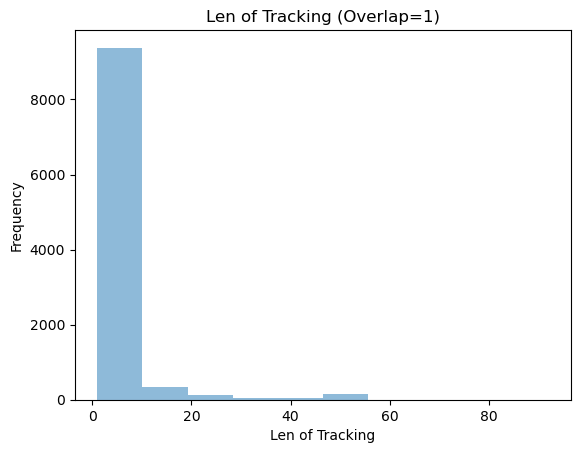

In [6]:
import numpy as np
import matplotlib.pyplot as plt

frame_diff = []
for frames, coordinates in trajectories:
    if (frames[-1]-frames[0]) >= 10:
        frame_diff.append(frames[-1]-frames[0])
    
hist, bins = np.histogram(frame_diff, bins=10)  # Adjust number of bins as needed
plt.hist(frame_diff, bins=bins, alpha=0.5)
plt.xlabel("Len of Tracking")
plt.ylabel("Frequency")
plt.title("Len of Tracking (Overlap=1)")
plt.show()

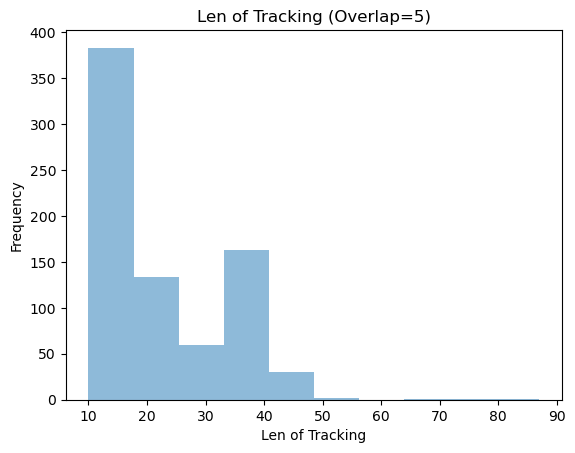

In [10]:
import numpy as np
import matplotlib.pyplot as plt

frame_diff = []
for frames, coordinates in trajectories:
    if (frames[-1]-frames[0]) >= 10:
        frame_diff.append(frames[-1]-frames[0])
    
hist, bins = np.histogram(frame_diff, bins=10)  # Adjust number of bins as needed
plt.hist(frame_diff, bins=bins, alpha=0.5)
plt.xlabel("Len of Tracking")
plt.ylabel("Frequency")
plt.title("Len of Tracking (Overlap=5)")
plt.show()

## MSD

In [1]:
import numpy as np
import math

def compute_msd_with_inconsistent_frames(trajectories):
    msds = []
    num_frames = max([max(frames) for frames,_ in trajectories])
    # Loop over each trajectory
    for frames, coordinates in trajectories:
        num_frames = len(frames)
        displacements = []

        # Loop over each possible lag time
        for tau in range(1, num_frames):
            squared_displacements = []
            
            # Loop over all pairs of frames with the correct time difference (tau)
            for i in range(num_frames):
                for j in range(i + 1, num_frames):
                    frame_diff = frames[j] - frames[i]  # Difference in frame numbers
                    if frame_diff == tau:
                        x1,y1 = coordinates[j]
                        x2, y2 = coordinates[i]
                        squared_displacement = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Sum of squares of displacements
                        squared_displacements.append(squared_displacement)
            
            # Only compute MSD if there are valid displacements for this tau
            if squared_displacements:
                mean_squared_displacement = np.mean(squared_displacements)
                displacements.append(mean_squared_displacement)
            else:
                # No valid displacements for this tau, so append NaN or skip
                displacements.append(np.nan)
        
        # Store the MSDs for this trajectory
        msds.append(displacements)
    
    return msds

#msd_results = compute_msd_with_inconsistent_frames(trajectories)

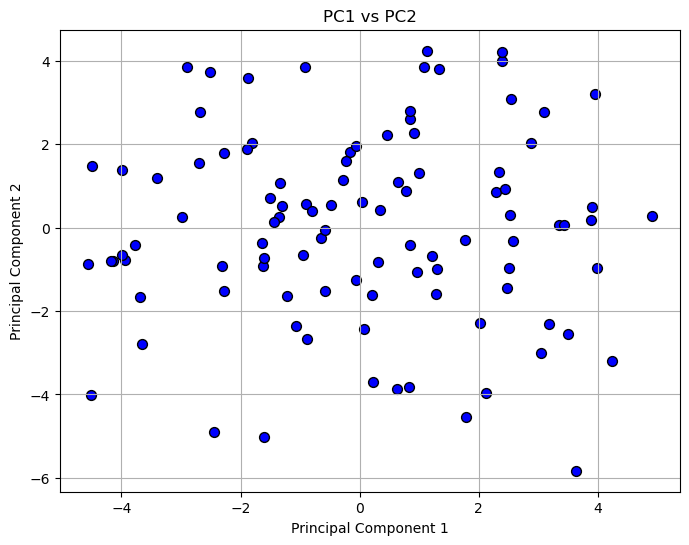

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Example: Randomly generated 2D trajectories with 100 time steps
n_trajectories = 100
time_steps = 100
data = np.random.rand(n_trajectories, time_steps, 2)  # 100 trajectories of 2D points

# Flatten each trajectory
flattened_data = data.reshape(n_trajectories, time_steps * 2)

# Standardize the data
scaler = StandardScaler()
flattened_data_std = scaler.fit_transform(flattened_data)

# Apply PCA
pca = PCA(n_components=10)  # Retain 10 principal components
principal_components = pca.fit_transform(flattened_data_std)
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]

# Plot PC1 against PC2
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, c='blue', marker='o', edgecolor='k', s=50)
plt.title('PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [3]:
from andi_datasets.models_phenom import models_phenom
import random
import numpy as np
traj_simu,_ = models_phenom().multi_state(
            N = 5,
            L = 20,
            T = 6,
            alphas =  [1.2, 0.7],
            Ds = [[10*0.1, 0.1], [1.2*0.1, 0.0]],
            M = [[0.98, 0.02], [0.02, 0.98]],
        )
print(traj_simu.shape[-1])
stacked_array = np.vstack([np.hstack([np.transpose(traj_simu[i,:, j]) for i in range(traj_simu.shape[0])]) 
                            for j in range(traj_simu.shape[-1])])
centroids = np.transpose(stacked_array) 
#print(centroids)
node_index_labels = np.hstack([np.arange(traj_simu.shape[1]) for idx in range(traj_simu.shape[0])]).astype(float)
node_index_labels /= 4.0
print(node_index_labels)
#print(centroids)
pool = []
for i in range(5):
    pool.extend([i] * min(2, 6 // 5 + 1))

# Randomly shuffle the pool and return the first N elements
random.shuffle(pool)
idx =  pool[:6]
print(idx)
del_idx = [index+5*i for i,index in enumerate(idx)]
print(del_idx)
node_index_labels_up = np.delete(node_index_labels, del_idx, axis=0)
print(node_index_labels_up)

2
[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5
 0.75 1.  ]
[2, 3, 3, 1, 4, 1]
[2, 8, 13, 16, 24, 26]
[0.   0.25 0.75 1.   0.   0.25 0.5  1.   0.   0.25 0.5  1.   0.   0.5
 0.75 1.   0.   0.25 0.5  0.75 0.   0.5  0.75 1.  ]


In [7]:
import random
pool = []
for i in range(20):
    pool.extend([i] * min(10, 30 // 20 + 1))

# Randomly shuffle the pool and return the first N elements
random.shuffle(pool)
idx =  pool[:(30*3)]
print(idx)
del_idx = [index+20*(i%3) for i,index in enumerate(idx)]
print(del_idx)

[14, 13, 13, 1, 15, 8, 1, 0, 6, 10, 14, 7, 4, 4, 9, 12, 17, 3, 19, 12, 15, 2, 7, 16, 11, 17, 6, 9, 0, 11, 18, 5, 8, 18, 19, 10, 5, 16, 2, 3]
[14, 33, 53, 1, 35, 48, 1, 20, 46, 10, 34, 47, 4, 24, 49, 12, 37, 43, 19, 32, 55, 2, 27, 56, 11, 37, 46, 9, 20, 51, 18, 25, 48, 18, 39, 50, 5, 36, 42, 3]


In [1]:
import random

random_numbers = [random.randint(0, 3) for _ in range(10)]
print(random_numbers)

[1, 0, 0, 3, 3, 3, 2, 3, 0, 0]
